In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
def load_results_dataset(runs_file_path, metric='f1_micro'):
    df = pd.read_csv(runs_file_path)
    rename_models = {
        "LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')": 'LogisticRegressionElasticnet',
        "LogisticRegression(penalty='l1', solver='liblinear')": 'LogisticRegressionLasso',
        "LogisticRegression()": "LogisticRegressionRidge",
        "LogisticRegression(penalty='none')": "LogisticRegression",
        "XGBClassifier(b": "XGBoost",
        "XGBRFClassifier": "RandomForestV2",
        "DummyClassifier(strategy='stratified')": "DummyClassifierStratified",
        "DummyClassifier(strategy='uniform')": "DummyClassifierUniform",
        "DummyClassifier()": "DummyClassifierMostFrequent",
        "LinearSVC()":"LinearSVC",
        "SVC()": "SVC",
        "RandomForestClassifier()": "RandomForestClassifier",
        "RidgeClassifier()": "RidgeClassifier",
        "MultinomialNB()": "NaiveBayes",
        "ComplementNB()": "NaiveBayesComplement"
    }

    df.model_type = df.model_type.map(rename_models)
    df = df[['model_type', 'unit_of_analysis', 'n_features', f'{metric}_mean', f'{metric}_std', 'language']]\
        .sort_values(['model_type', 'unit_of_analysis'])

    df['model_type'] = pd.Categorical(df['model_type'], categories= df['model_type'].unique(), ordered=True)
    df['language'] = pd.Categorical(df['language'], categories=['en', 'it', 'fr', 'po', 'ru', 'ge'], ordered=True)

    return df

In [3]:
def plot_performance_wo_error_bars(df, title, figsize=(20, 10), ylab='f1-micro'):
    fig = plt.figure(figsize=figsize)
    ax = sns.pointplot(
        data=df.reset_index(),
        x='model_type',
        y='f1_micro_mean',
        hue='unit_of_analysis',
        join=False
    )

    plt.title(title, fontsize=24)
    plt.ylabel(ylab)
    plt.xticks(rotation=90)
    plt.show()

def plot_performance_with_error_bars(df, title, figsize=(20, 10), ylab='f1-micro'):
    fig = plt.figure(figsize=figsize)

    for unit_of_analysis, df_i in df.groupby('unit_of_analysis'):
        df_i = df_i.sort_values(['model_type']).reset_index()
        plt.errorbar(df_i.model_type, df_i.f1_micro_mean, yerr=df_i.f1_micro_std, linestyle='',  capsize=5, alpha=0.8)
        plt.scatter(df_i.model_type, df_i.f1_micro_mean, label=unit_of_analysis)

    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel(ylab)
    plt.legend()
    plt.ylim(0,1)
    plt.show()

In [4]:
def display_performance_table(df, display_=True):
    report_table = df.copy()
    report_table['result'] = report_table.f1_micro_mean.map(lambda x: f'{x:.2f}') + ' $\pm$ ' + report_table.f1_micro_std.map(lambda x: f'{x:.2f}')
    report_table['col_title'] = report_table.unit_of_analysis.str.split('_').str.join(' ') + ' (' + report_table.n_features.astype(str) + ' features)'
    report_table['col_title'] = pd.Categorical(
        report_table.col_title,
        categories=report_table[['n_features', 'col_title']].drop_duplicates().sort_values('n_features').col_title.to_list(),
        ordered=True)
    report_table = report_table[['model_type', 'col_title', 'result']]\
        .pivot_table(index='model_type', columns=['col_title'], values=['result'], aggfunc='first', fill_value=0)\
        .droplevel(0, axis=1)

    report_table.columns.names = [None]

    # Highlight best scoring models according to their average
    mean_perf_arr = report_table.applymap(lambda x: float(str(x).split(' ')[0])).to_numpy()
    highlight_mask = mean_perf_arr == mean_perf_arr.max()
    report_table_arr = report_table.to_numpy()  # Note it passes the array by reference
    report_table_arr[highlight_mask] = '**' + report_table_arr[highlight_mask] + '**'

    if display_:
        display(Markdown(report_table.to_markdown()))
    else:
        return report_table.to_markdown()

# Report model performance (models with default parameters)

#### Findings
The low availability of labeled data makes it so that they can handle even less complexity, so often some of the more complex models underfit and perform worse than the Dummy baselines. In almost all the cases, the best performance happens for the highest number of features used. However, for most languages except english, most metrics are within the margin of error for the different units of analysis (except for using just the title). This is because the english dataset has much more samples, so the variation between test folds is not so large.

The models should be less complex and/or trained for much longer (avoid underfitting) if we want to regularize them more heavily.

The best performing models, in decreasing order, with default parameters are the following:

   * English: RandomForest, RidgecClassifier, LinearSVC, and SVC, NaiveBayes
   * Italian: NaiveBayesComplement, LogisticRegression, RandomForest
   * French: LinearSVC, NaiveBayesComplement, RandomForestV2, XGBoost
   * Polish: LogisticRegression, LinearSVC, RandomForest
   * Russian: XGBoost, LinearSVC, LogisticRegression
   * German:  LogisticRegression, NaiveBayesComplement, RandomForestV2



# Performance in the language: en

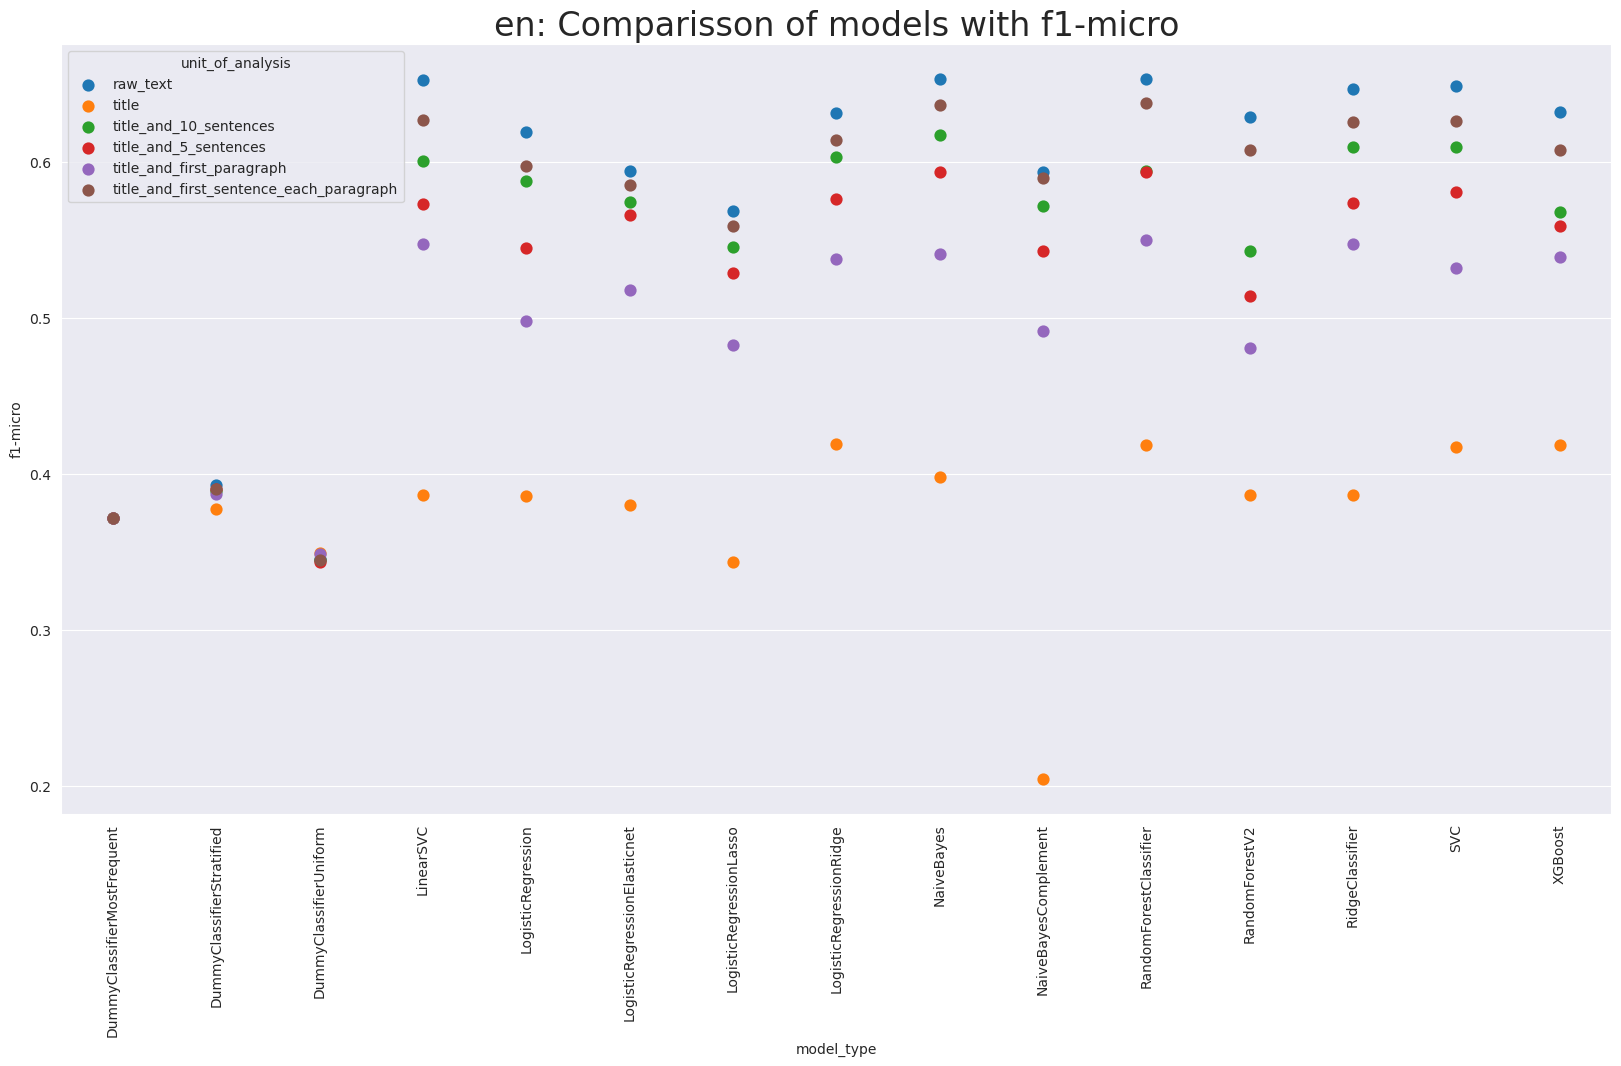

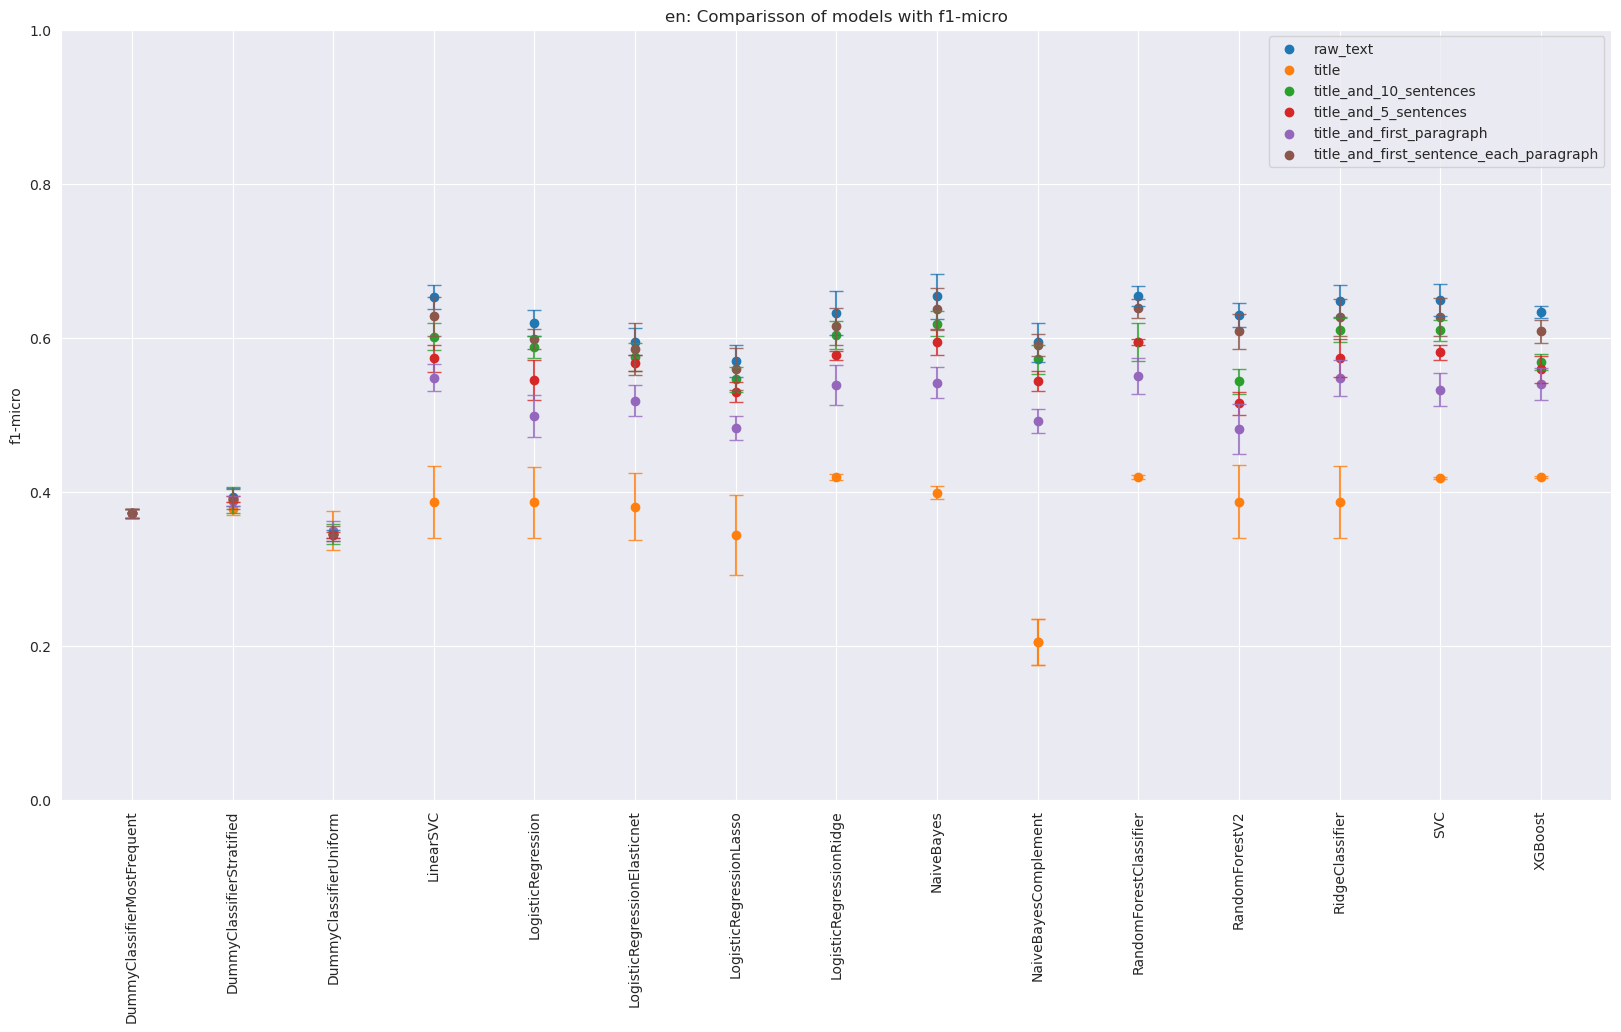



### f1-micro mean performance

| model_type                   | title (3 features)   | title and first paragraph (77 features)   | title and 5 sentences (168 features)   | title and 10 sentences (328 features)   | title and first sentence each paragraph (666 features)   | raw text (1208 features)   |
|:-----------------------------|:---------------------|:------------------------------------------|:---------------------------------------|:----------------------------------------|:---------------------------------------------------------|:---------------------------|
| DummyClassifierMostFrequent  | 0.37 $\pm$ 0.01      | 0.37 $\pm$ 0.01                           | 0.37 $\pm$ 0.01                        | 0.37 $\pm$ 0.01                         | 0.37 $\pm$ 0.01                                          | 0.37 $\pm$ 0.01            |
| DummyClassifierStratified    | 0.38 $\pm$ 0.01      | 0.39 $\pm$ 0.01                           | 0.39 $\pm$ 0.00                        | 0.39 $\pm$ 0.02                         | 0.39 $\pm$ 0.01                                          | 0.39 $\pm$ 0.01            |
| DummyClassifierUniform       | 0.35 $\pm$ 0.03      | 0.35 $\pm$ 0.01                           | 0.34 $\pm$ 0.00                        | 0.34 $\pm$ 0.01                         | 0.35 $\pm$ 0.01                                          | 0.35 $\pm$ 0.01            |
| LinearSVC                    | 0.39 $\pm$ 0.05      | 0.55 $\pm$ 0.02                           | 0.57 $\pm$ 0.02                        | 0.60 $\pm$ 0.02                         | 0.63 $\pm$ 0.03                                          | **0.65 $\pm$ 0.02**        |
| LogisticRegression           | 0.39 $\pm$ 0.05      | 0.50 $\pm$ 0.03                           | 0.54 $\pm$ 0.03                        | 0.59 $\pm$ 0.01                         | 0.60 $\pm$ 0.01                                          | 0.62 $\pm$ 0.02            |
| LogisticRegressionElasticnet | 0.38 $\pm$ 0.04      | 0.52 $\pm$ 0.02                           | 0.57 $\pm$ 0.01                        | 0.57 $\pm$ 0.02                         | 0.59 $\pm$ 0.03                                          | 0.59 $\pm$ 0.02            |
| LogisticRegressionLasso      | 0.34 $\pm$ 0.05      | 0.48 $\pm$ 0.02                           | 0.53 $\pm$ 0.01                        | 0.55 $\pm$ 0.02                         | 0.56 $\pm$ 0.03                                          | 0.57 $\pm$ 0.02            |
| LogisticRegressionRidge      | 0.42 $\pm$ 0.00      | 0.54 $\pm$ 0.03                           | 0.58 $\pm$ 0.01                        | 0.60 $\pm$ 0.02                         | 0.61 $\pm$ 0.02                                          | 0.63 $\pm$ 0.03            |
| NaiveBayes                   | 0.40 $\pm$ 0.01      | 0.54 $\pm$ 0.02                           | 0.59 $\pm$ 0.02                        | 0.62 $\pm$ 0.02                         | 0.64 $\pm$ 0.03                                          | **0.65 $\pm$ 0.03**        |
| NaiveBayesComplement         | 0.20 $\pm$ 0.03      | 0.49 $\pm$ 0.02                           | 0.54 $\pm$ 0.01                        | 0.57 $\pm$ 0.02                         | 0.59 $\pm$ 0.01                                          | 0.59 $\pm$ 0.03            |
| RandomForestClassifier       | 0.42 $\pm$ 0.00      | 0.55 $\pm$ 0.02                           | 0.59 $\pm$ 0.00                        | 0.59 $\pm$ 0.02                         | 0.64 $\pm$ 0.01                                          | **0.65 $\pm$ 0.01**        |
| RandomForestV2               | 0.39 $\pm$ 0.05      | 0.48 $\pm$ 0.03                           | 0.51 $\pm$ 0.01                        | 0.54 $\pm$ 0.02                         | 0.61 $\pm$ 0.02                                          | 0.63 $\pm$ 0.02            |
| RidgeClassifier              | 0.39 $\pm$ 0.05      | 0.55 $\pm$ 0.02                           | 0.57 $\pm$ 0.02                        | 0.61 $\pm$ 0.02                         | 0.63 $\pm$ 0.02                                          | **0.65 $\pm$ 0.02**        |
| SVC                          | 0.42 $\pm$ 0.00      | 0.53 $\pm$ 0.02                           | 0.58 $\pm$ 0.01                        | 0.61 $\pm$ 0.01                         | 0.63 $\pm$ 0.02                                          | **0.65 $\pm$ 0.02**        |
| XGBoost                      | 0.42 $\pm$ 0.00      | 0.54 $\pm$ 0.02                           | 0.56 $\pm$ 0.02                        | 0.57 $\pm$ 0.01                         | 0.61 $\pm$ 0.01                                          | 0.63 $\pm$ 0.01            |

# Performance in the language: it

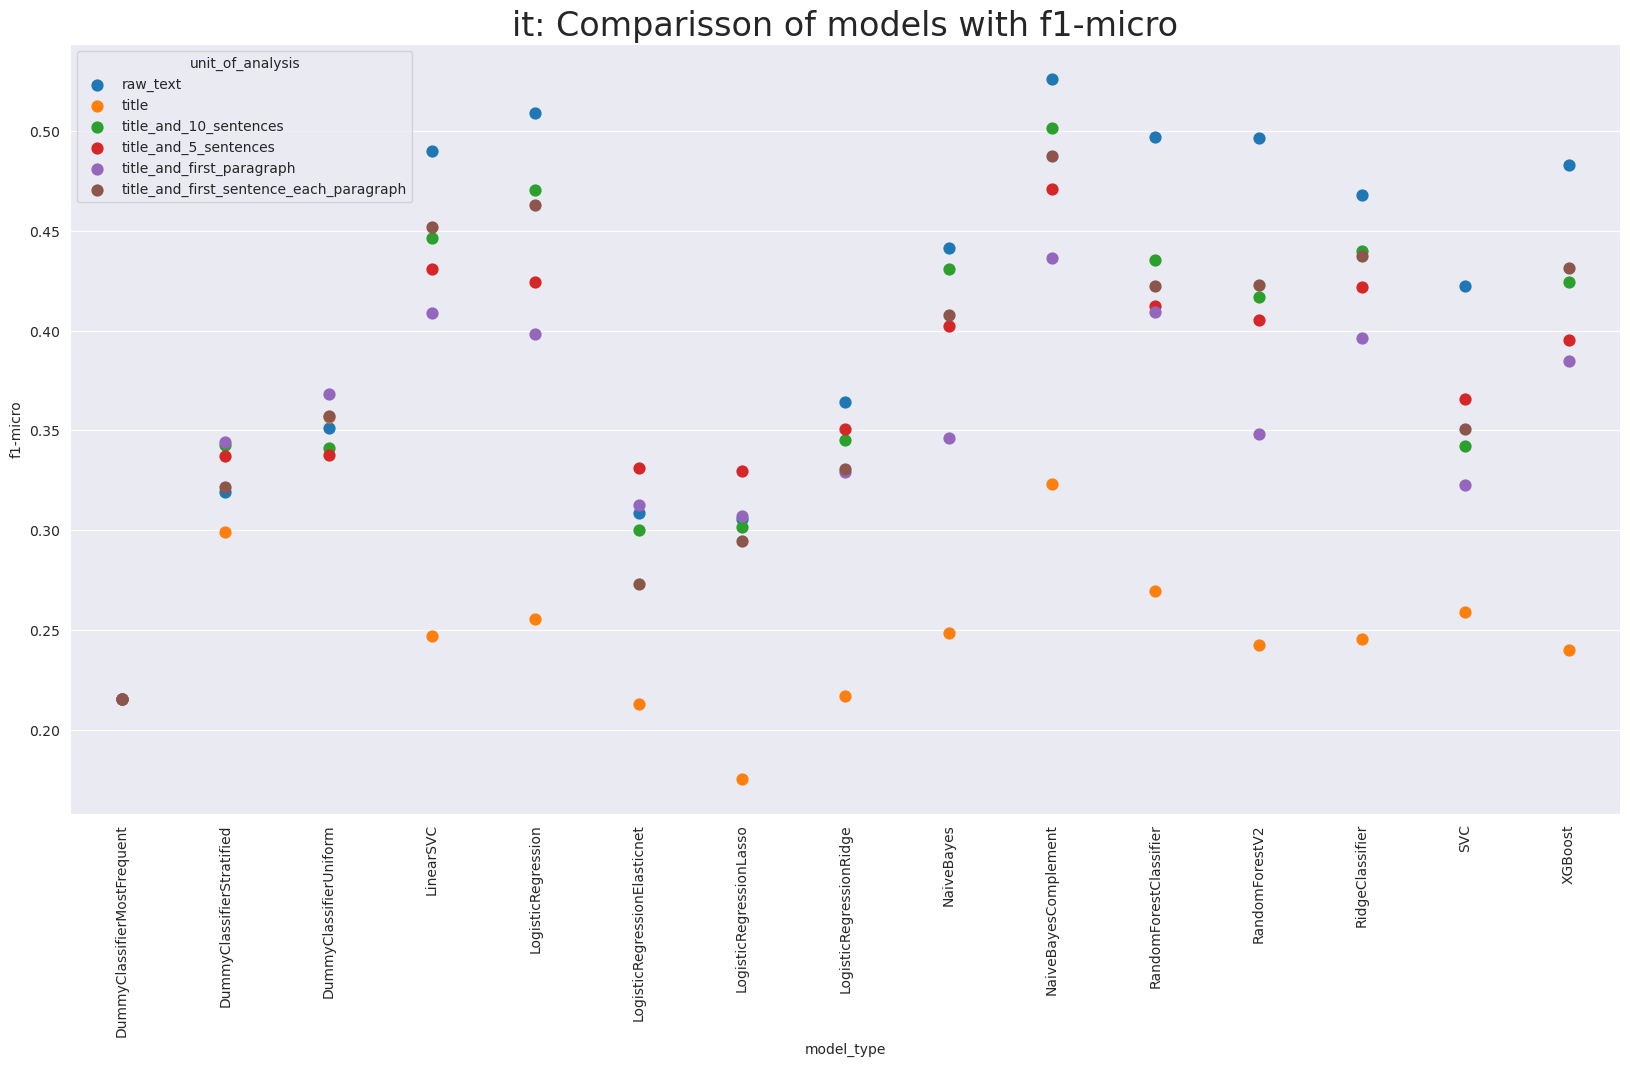

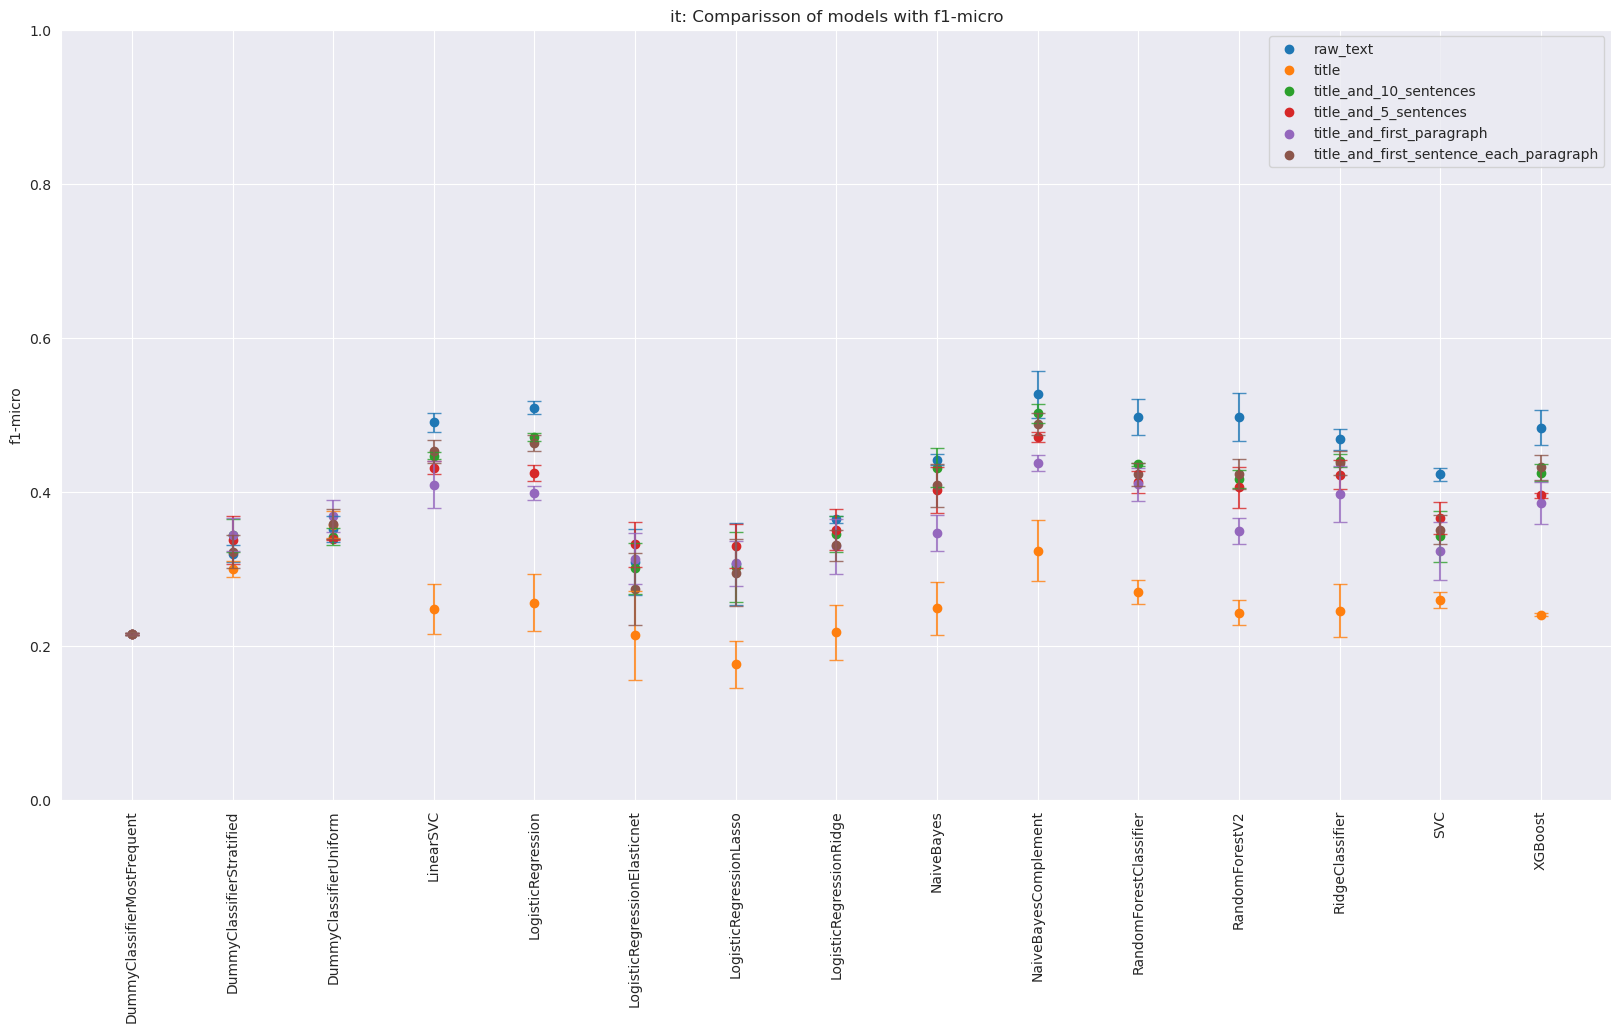



### f1-micro mean performance

| model_type                   | title (8 features)   | title and first paragraph (53 features)   | title and 5 sentences (96 features)   | title and 10 sentences (296 features)   | title and first sentence each paragraph (312 features)   | raw text (967 features)   |
|:-----------------------------|:---------------------|:------------------------------------------|:--------------------------------------|:----------------------------------------|:---------------------------------------------------------|:--------------------------|
| DummyClassifierMostFrequent  | 0.22 $\pm$ 0.00      | 0.22 $\pm$ 0.00                           | 0.22 $\pm$ 0.00                       | 0.22 $\pm$ 0.00                         | 0.22 $\pm$ 0.00                                          | 0.22 $\pm$ 0.00           |
| DummyClassifierStratified    | 0.30 $\pm$ 0.01      | 0.34 $\pm$ 0.02                           | 0.34 $\pm$ 0.03                       | 0.34 $\pm$ 0.02                         | 0.32 $\pm$ 0.02                                          | 0.32 $\pm$ 0.01           |
| DummyClassifierUniform       | 0.36 $\pm$ 0.02      | 0.37 $\pm$ 0.02                           | 0.34 $\pm$ 0.00                       | 0.34 $\pm$ 0.01                         | 0.36 $\pm$ 0.02                                          | 0.35 $\pm$ 0.02           |
| LinearSVC                    | 0.25 $\pm$ 0.03      | 0.41 $\pm$ 0.03                           | 0.43 $\pm$ 0.01                       | 0.45 $\pm$ 0.00                         | 0.45 $\pm$ 0.02                                          | 0.49 $\pm$ 0.01           |
| LogisticRegression           | 0.26 $\pm$ 0.04      | 0.40 $\pm$ 0.01                           | 0.42 $\pm$ 0.01                       | 0.47 $\pm$ 0.01                         | 0.46 $\pm$ 0.01                                          | 0.51 $\pm$ 0.01           |
| LogisticRegressionElasticnet | 0.21 $\pm$ 0.06      | 0.31 $\pm$ 0.03                           | 0.33 $\pm$ 0.03                       | 0.30 $\pm$ 0.03                         | 0.27 $\pm$ 0.05                                          | 0.31 $\pm$ 0.04           |
| LogisticRegressionLasso      | 0.18 $\pm$ 0.03      | 0.31 $\pm$ 0.03                           | 0.33 $\pm$ 0.03                       | 0.30 $\pm$ 0.05                         | 0.29 $\pm$ 0.04                                          | 0.31 $\pm$ 0.05           |
| LogisticRegressionRidge      | 0.22 $\pm$ 0.04      | 0.33 $\pm$ 0.04                           | 0.35 $\pm$ 0.03                       | 0.35 $\pm$ 0.02                         | 0.33 $\pm$ 0.02                                          | 0.36 $\pm$ 0.00           |
| NaiveBayes                   | 0.25 $\pm$ 0.03      | 0.35 $\pm$ 0.02                           | 0.40 $\pm$ 0.03                       | 0.43 $\pm$ 0.03                         | 0.41 $\pm$ 0.03                                          | 0.44 $\pm$ 0.01           |
| NaiveBayesComplement         | 0.32 $\pm$ 0.04      | 0.44 $\pm$ 0.01                           | 0.47 $\pm$ 0.01                       | 0.50 $\pm$ 0.01                         | 0.49 $\pm$ 0.01                                          | **0.53 $\pm$ 0.03**       |
| RandomForestClassifier       | 0.27 $\pm$ 0.02      | 0.41 $\pm$ 0.02                           | 0.41 $\pm$ 0.01                       | 0.44 $\pm$ 0.00                         | 0.42 $\pm$ 0.01                                          | 0.50 $\pm$ 0.02           |
| RandomForestV2               | 0.24 $\pm$ 0.02      | 0.35 $\pm$ 0.02                           | 0.41 $\pm$ 0.03                       | 0.42 $\pm$ 0.01                         | 0.42 $\pm$ 0.02                                          | 0.50 $\pm$ 0.03           |
| RidgeClassifier              | 0.25 $\pm$ 0.03      | 0.40 $\pm$ 0.04                           | 0.42 $\pm$ 0.02                       | 0.44 $\pm$ 0.01                         | 0.44 $\pm$ 0.02                                          | 0.47 $\pm$ 0.01           |
| SVC                          | 0.26 $\pm$ 0.01      | 0.32 $\pm$ 0.04                           | 0.37 $\pm$ 0.02                       | 0.34 $\pm$ 0.03                         | 0.35 $\pm$ 0.02                                          | 0.42 $\pm$ 0.01           |
| XGBoost                      | 0.24 $\pm$ 0.00      | 0.38 $\pm$ 0.03                           | 0.40 $\pm$ 0.00                       | 0.42 $\pm$ 0.01                         | 0.43 $\pm$ 0.02                                          | 0.48 $\pm$ 0.02           |

# Performance in the language: fr

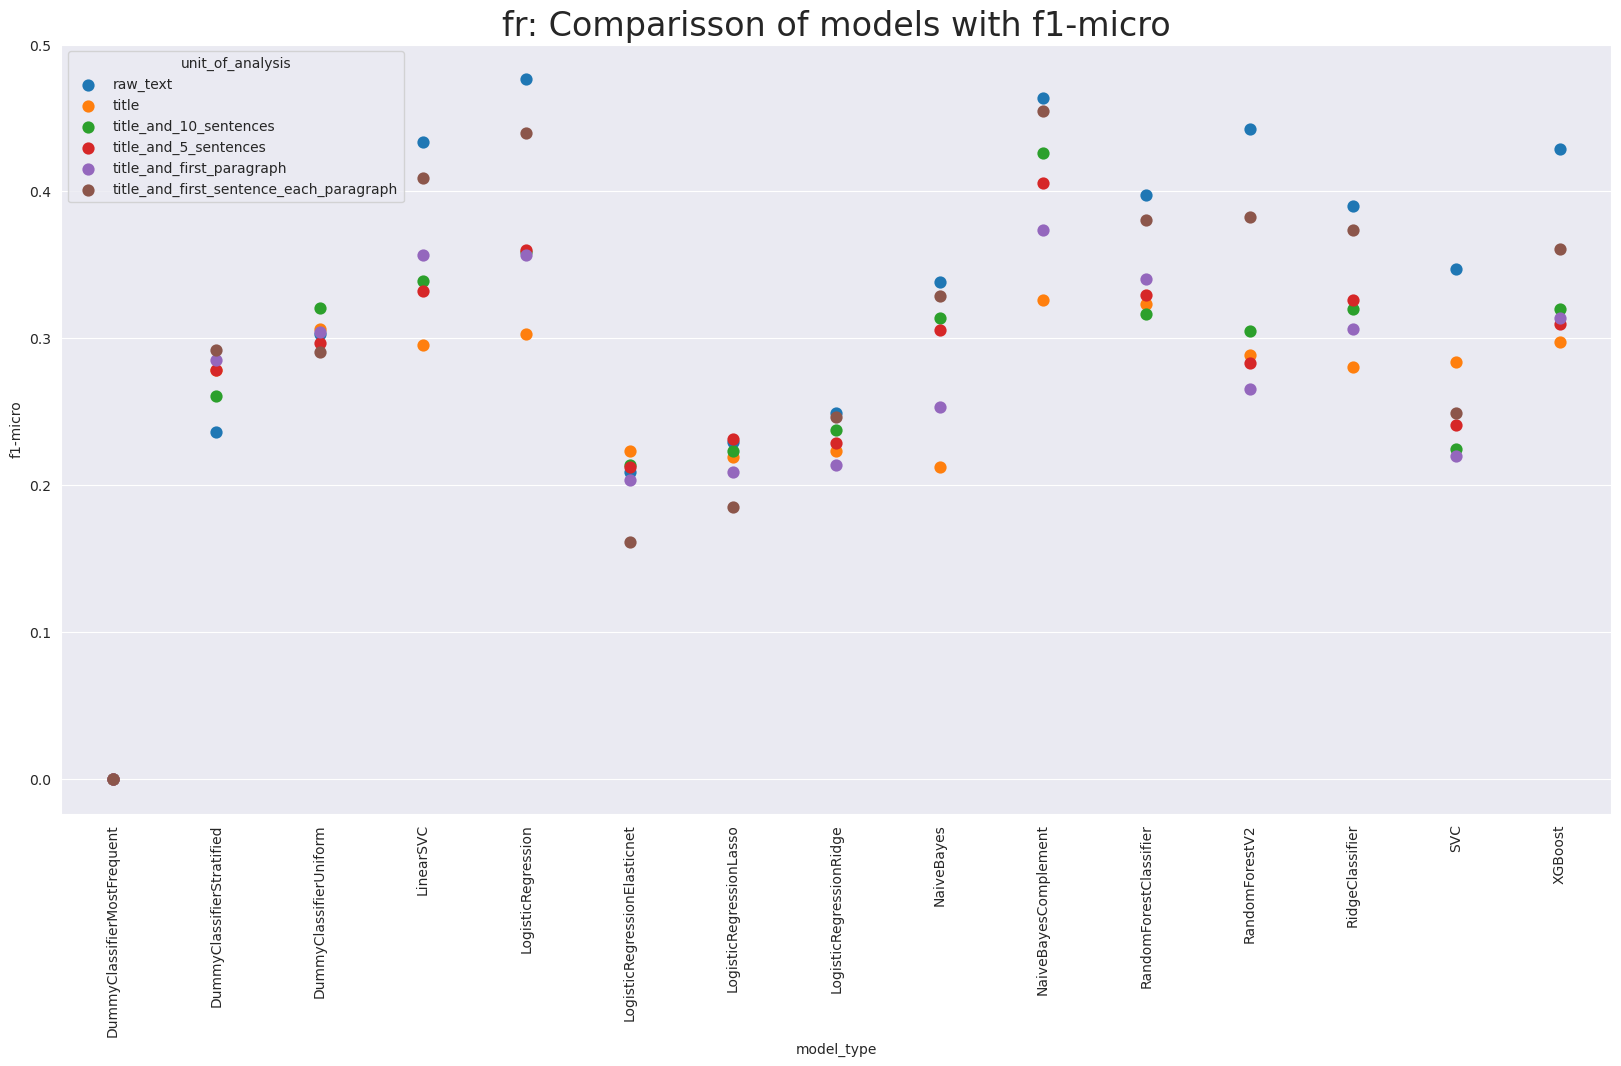

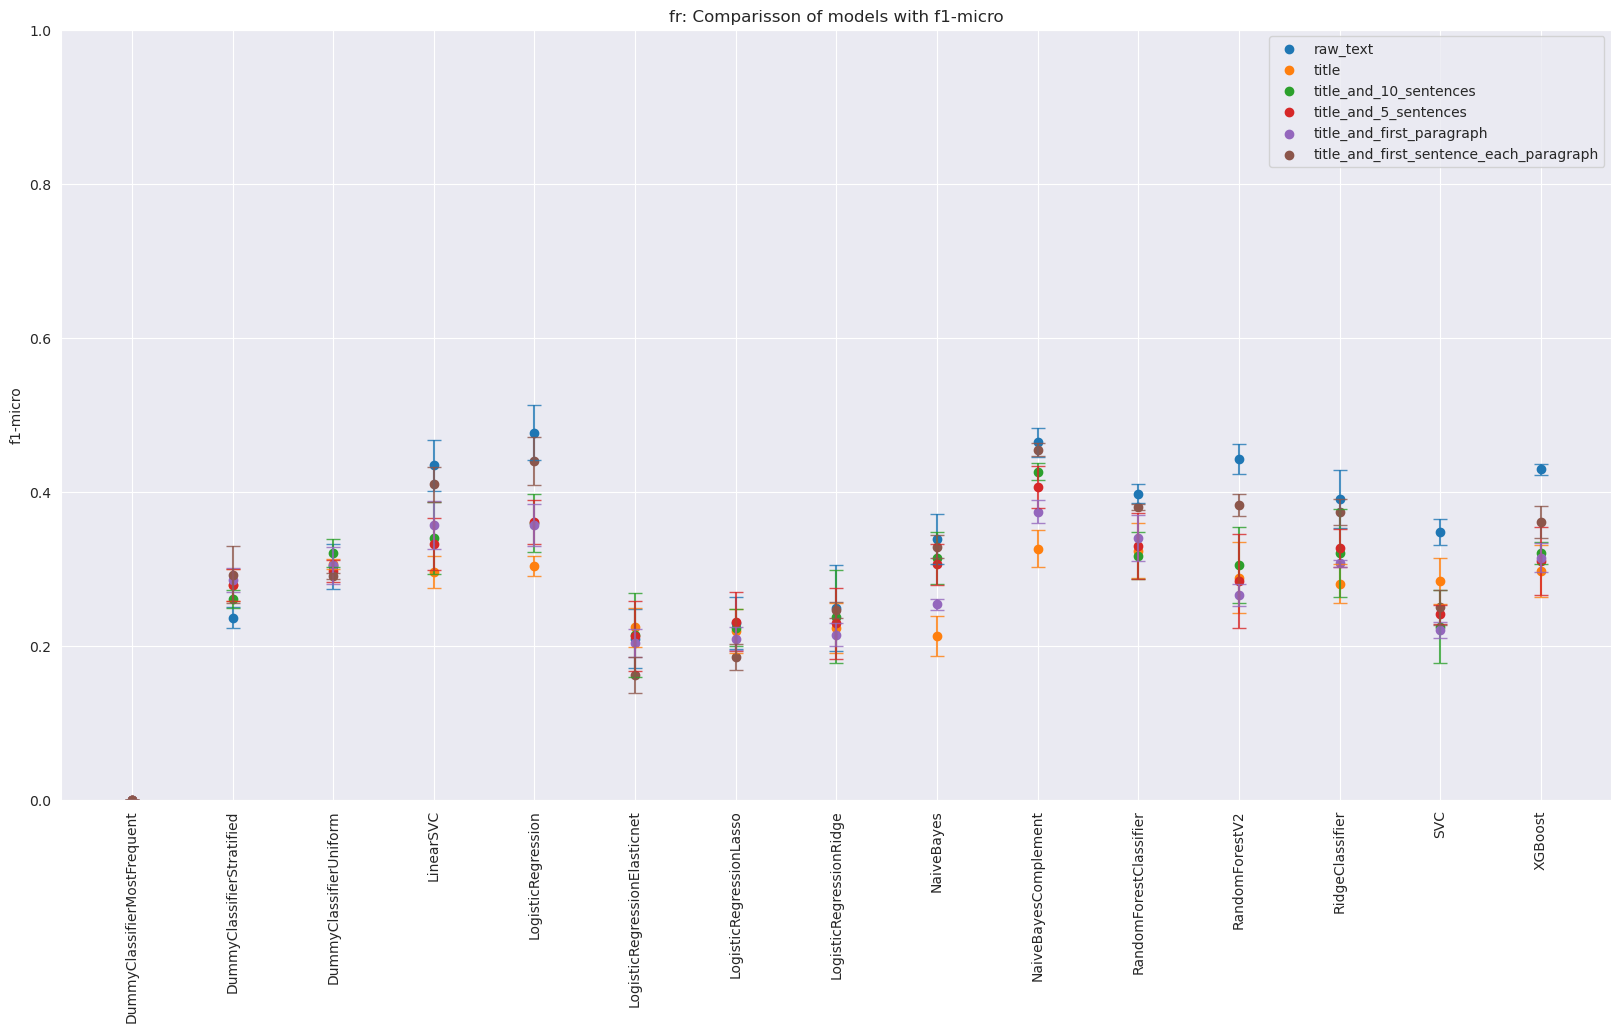



### f1-micro mean performance

| model_type                   | title (9 features)   | title and first paragraph (72 features)   | title and 5 sentences (107 features)   | title and 10 sentences (283 features)   | title and first sentence each paragraph (405 features)   | raw text (1190 features)   |
|:-----------------------------|:---------------------|:------------------------------------------|:---------------------------------------|:----------------------------------------|:---------------------------------------------------------|:---------------------------|
| DummyClassifierMostFrequent  | 0.00 $\pm$ 0.00      | 0.00 $\pm$ 0.00                           | 0.00 $\pm$ 0.00                        | 0.00 $\pm$ 0.00                         | 0.00 $\pm$ 0.00                                          | 0.00 $\pm$ 0.00            |
| DummyClassifierStratified    | 0.28 $\pm$ 0.02      | 0.29 $\pm$ 0.02                           | 0.28 $\pm$ 0.02                        | 0.26 $\pm$ 0.01                         | 0.29 $\pm$ 0.04                                          | 0.24 $\pm$ 0.01            |
| DummyClassifierUniform       | 0.31 $\pm$ 0.01      | 0.30 $\pm$ 0.02                           | 0.30 $\pm$ 0.01                        | 0.32 $\pm$ 0.02                         | 0.29 $\pm$ 0.00                                          | 0.30 $\pm$ 0.03            |
| LinearSVC                    | 0.30 $\pm$ 0.02      | 0.36 $\pm$ 0.03                           | 0.33 $\pm$ 0.03                        | 0.34 $\pm$ 0.05                         | 0.41 $\pm$ 0.02                                          | 0.43 $\pm$ 0.03            |
| LogisticRegression           | 0.30 $\pm$ 0.01      | 0.36 $\pm$ 0.03                           | 0.36 $\pm$ 0.03                        | 0.36 $\pm$ 0.04                         | 0.44 $\pm$ 0.03                                          | **0.48 $\pm$ 0.04**        |
| LogisticRegressionElasticnet | 0.22 $\pm$ 0.03      | 0.20 $\pm$ 0.02                           | 0.21 $\pm$ 0.05                        | 0.21 $\pm$ 0.05                         | 0.16 $\pm$ 0.02                                          | 0.21 $\pm$ 0.04            |
| LogisticRegressionLasso      | 0.22 $\pm$ 0.03      | 0.21 $\pm$ 0.01                           | 0.23 $\pm$ 0.04                        | 0.22 $\pm$ 0.02                         | 0.19 $\pm$ 0.02                                          | 0.23 $\pm$ 0.03            |
| LogisticRegressionRidge      | 0.22 $\pm$ 0.03      | 0.21 $\pm$ 0.02                           | 0.23 $\pm$ 0.05                        | 0.24 $\pm$ 0.06                         | 0.25 $\pm$ 0.01                                          | 0.25 $\pm$ 0.06            |
| NaiveBayes                   | 0.21 $\pm$ 0.03      | 0.25 $\pm$ 0.01                           | 0.31 $\pm$ 0.03                        | 0.31 $\pm$ 0.03                         | 0.33 $\pm$ 0.02                                          | 0.34 $\pm$ 0.03            |
| NaiveBayesComplement         | 0.33 $\pm$ 0.02      | 0.37 $\pm$ 0.02                           | 0.41 $\pm$ 0.03                        | 0.43 $\pm$ 0.01                         | 0.45 $\pm$ 0.01                                          | 0.46 $\pm$ 0.02            |
| RandomForestClassifier       | 0.32 $\pm$ 0.04      | 0.34 $\pm$ 0.03                           | 0.33 $\pm$ 0.04                        | 0.32 $\pm$ 0.03                         | 0.38 $\pm$ 0.00                                          | 0.40 $\pm$ 0.01            |
| RandomForestV2               | 0.29 $\pm$ 0.05      | 0.27 $\pm$ 0.01                           | 0.28 $\pm$ 0.06                        | 0.30 $\pm$ 0.05                         | 0.38 $\pm$ 0.01                                          | 0.44 $\pm$ 0.02            |
| RidgeClassifier              | 0.28 $\pm$ 0.03      | 0.31 $\pm$ 0.00                           | 0.33 $\pm$ 0.02                        | 0.32 $\pm$ 0.06                         | 0.37 $\pm$ 0.02                                          | 0.39 $\pm$ 0.04            |
| SVC                          | 0.28 $\pm$ 0.03      | 0.22 $\pm$ 0.01                           | 0.24 $\pm$ 0.01                        | 0.22 $\pm$ 0.05                         | 0.25 $\pm$ 0.02                                          | 0.35 $\pm$ 0.02            |
| XGBoost                      | 0.30 $\pm$ 0.03      | 0.31 $\pm$ 0.02                           | 0.31 $\pm$ 0.04                        | 0.32 $\pm$ 0.01                         | 0.36 $\pm$ 0.02                                          | 0.43 $\pm$ 0.01            |

# Performance in the language: po

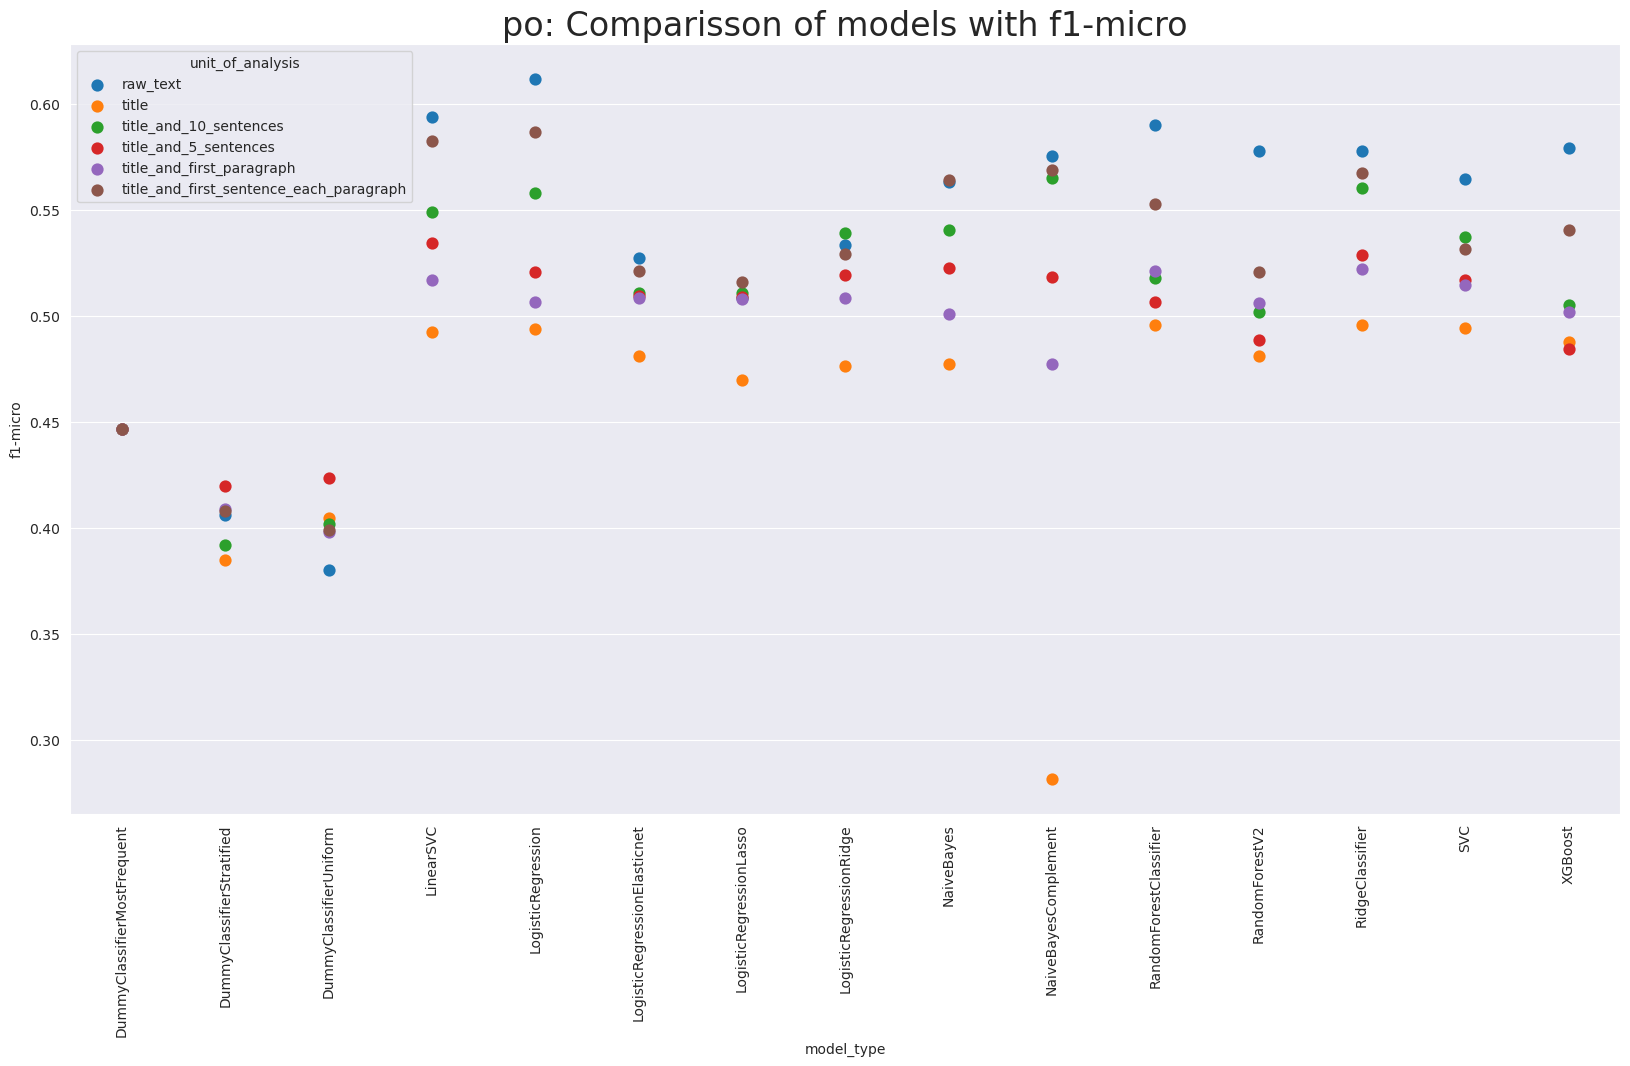

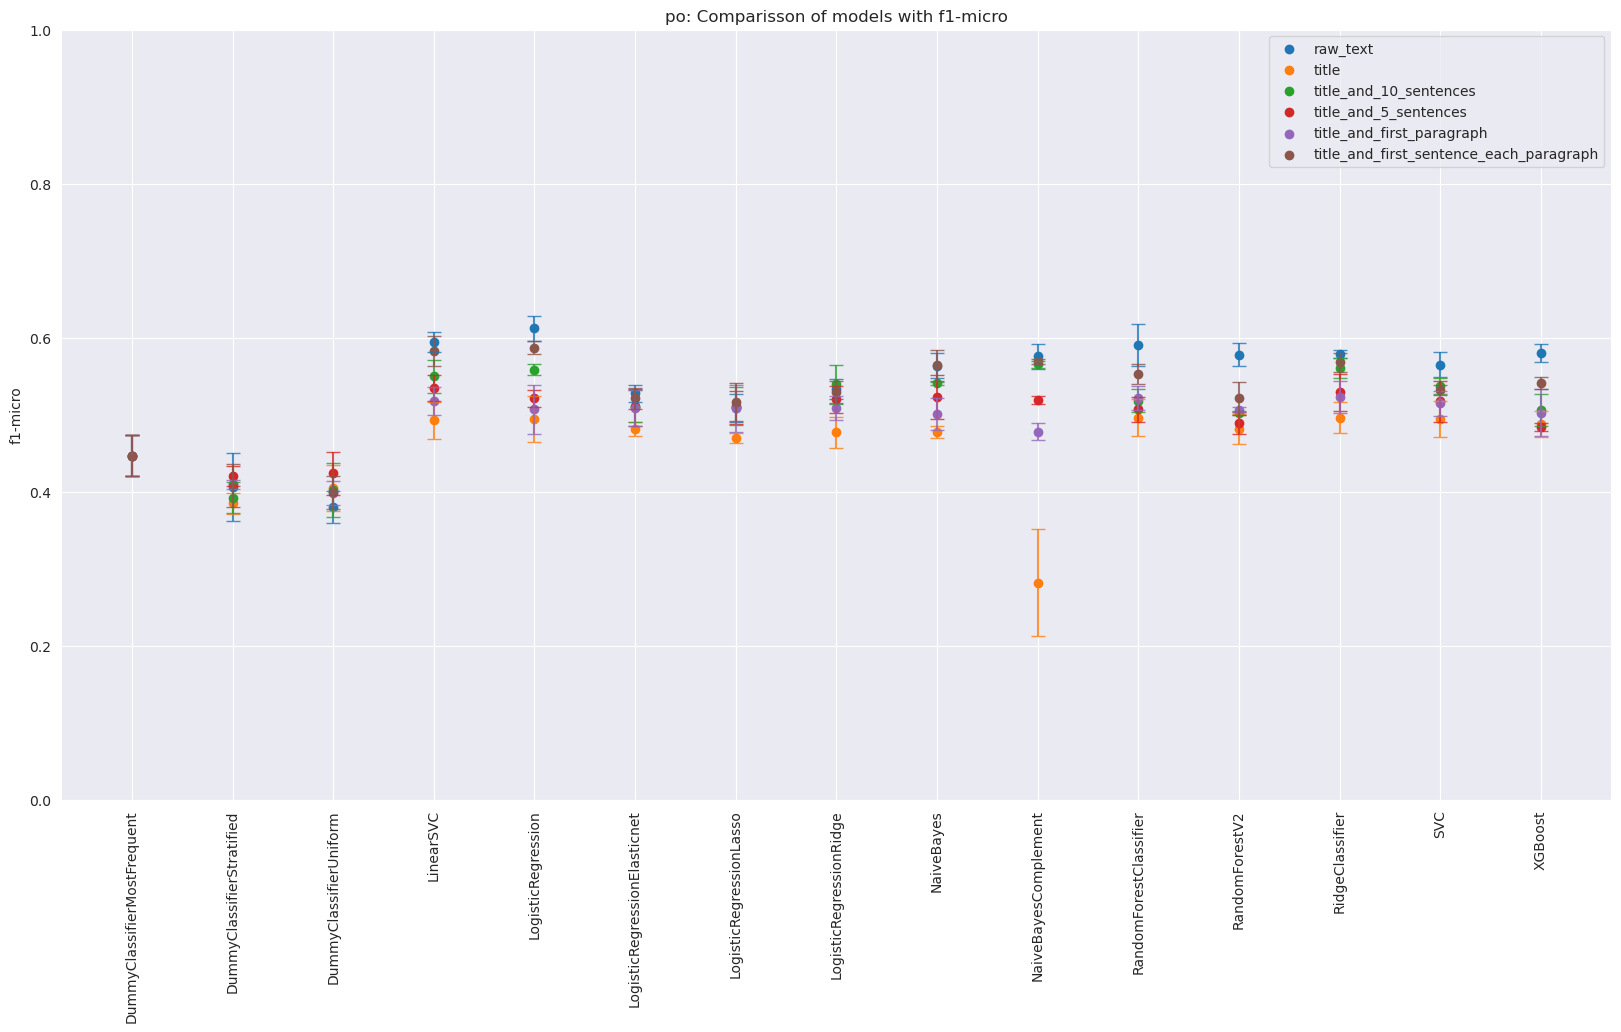



### f1-micro mean performance

| model_type                   | title (8 features)   | title and first paragraph (42 features)   | title and 5 sentences (114 features)   | title and 10 sentences (290 features)   | title and first sentence each paragraph (462 features)   | raw text (1336 features)   |
|:-----------------------------|:---------------------|:------------------------------------------|:---------------------------------------|:----------------------------------------|:---------------------------------------------------------|:---------------------------|
| DummyClassifierMostFrequent  | 0.45 $\pm$ 0.03      | 0.45 $\pm$ 0.03                           | 0.45 $\pm$ 0.03                        | 0.45 $\pm$ 0.03                         | 0.45 $\pm$ 0.03                                          | 0.45 $\pm$ 0.03            |
| DummyClassifierStratified    | 0.38 $\pm$ 0.01      | 0.41 $\pm$ 0.01                           | 0.42 $\pm$ 0.01                        | 0.39 $\pm$ 0.02                         | 0.41 $\pm$ 0.03                                          | 0.41 $\pm$ 0.04            |
| DummyClassifierUniform       | 0.40 $\pm$ 0.03      | 0.40 $\pm$ 0.02                           | 0.42 $\pm$ 0.03                        | 0.40 $\pm$ 0.03                         | 0.40 $\pm$ 0.02                                          | 0.38 $\pm$ 0.02            |
| LinearSVC                    | 0.49 $\pm$ 0.02      | 0.52 $\pm$ 0.02                           | 0.53 $\pm$ 0.02                        | 0.55 $\pm$ 0.02                         | 0.58 $\pm$ 0.02                                          | 0.59 $\pm$ 0.01            |
| LogisticRegression           | 0.49 $\pm$ 0.03      | 0.51 $\pm$ 0.03                           | 0.52 $\pm$ 0.01                        | 0.56 $\pm$ 0.01                         | 0.59 $\pm$ 0.01                                          | **0.61 $\pm$ 0.02**        |
| LogisticRegressionElasticnet | 0.48 $\pm$ 0.01      | 0.51 $\pm$ 0.02                           | 0.51 $\pm$ 0.02                        | 0.51 $\pm$ 0.02                         | 0.52 $\pm$ 0.01                                          | 0.53 $\pm$ 0.01            |
| LogisticRegressionLasso      | 0.47 $\pm$ 0.01      | 0.51 $\pm$ 0.03                           | 0.51 $\pm$ 0.02                        | 0.51 $\pm$ 0.02                         | 0.52 $\pm$ 0.02                                          | 0.51 $\pm$ 0.02            |
| LogisticRegressionRidge      | 0.48 $\pm$ 0.02      | 0.51 $\pm$ 0.02                           | 0.52 $\pm$ 0.02                        | 0.54 $\pm$ 0.02                         | 0.53 $\pm$ 0.01                                          | 0.53 $\pm$ 0.01            |
| NaiveBayes                   | 0.48 $\pm$ 0.01      | 0.50 $\pm$ 0.02                           | 0.52 $\pm$ 0.03                        | 0.54 $\pm$ 0.00                         | 0.56 $\pm$ 0.02                                          | 0.56 $\pm$ 0.02            |
| NaiveBayesComplement         | 0.28 $\pm$ 0.07      | 0.48 $\pm$ 0.01                           | 0.52 $\pm$ 0.01                        | 0.57 $\pm$ 0.00                         | 0.57 $\pm$ 0.00                                          | 0.58 $\pm$ 0.02            |
| RandomForestClassifier       | 0.50 $\pm$ 0.02      | 0.52 $\pm$ 0.02                           | 0.51 $\pm$ 0.02                        | 0.52 $\pm$ 0.02                         | 0.55 $\pm$ 0.01                                          | 0.59 $\pm$ 0.03            |
| RandomForestV2               | 0.48 $\pm$ 0.02      | 0.51 $\pm$ 0.00                           | 0.49 $\pm$ 0.01                        | 0.50 $\pm$ 0.00                         | 0.52 $\pm$ 0.02                                          | 0.58 $\pm$ 0.02            |
| RidgeClassifier              | 0.50 $\pm$ 0.02      | 0.52 $\pm$ 0.02                           | 0.53 $\pm$ 0.02                        | 0.56 $\pm$ 0.01                         | 0.57 $\pm$ 0.01                                          | 0.58 $\pm$ 0.01            |
| SVC                          | 0.49 $\pm$ 0.02      | 0.51 $\pm$ 0.02                           | 0.52 $\pm$ 0.03                        | 0.54 $\pm$ 0.01                         | 0.53 $\pm$ 0.01                                          | 0.56 $\pm$ 0.02            |
| XGBoost                      | 0.49 $\pm$ 0.02      | 0.50 $\pm$ 0.03                           | 0.48 $\pm$ 0.01                        | 0.51 $\pm$ 0.02                         | 0.54 $\pm$ 0.01                                          | 0.58 $\pm$ 0.01            |

# Performance in the language: ru

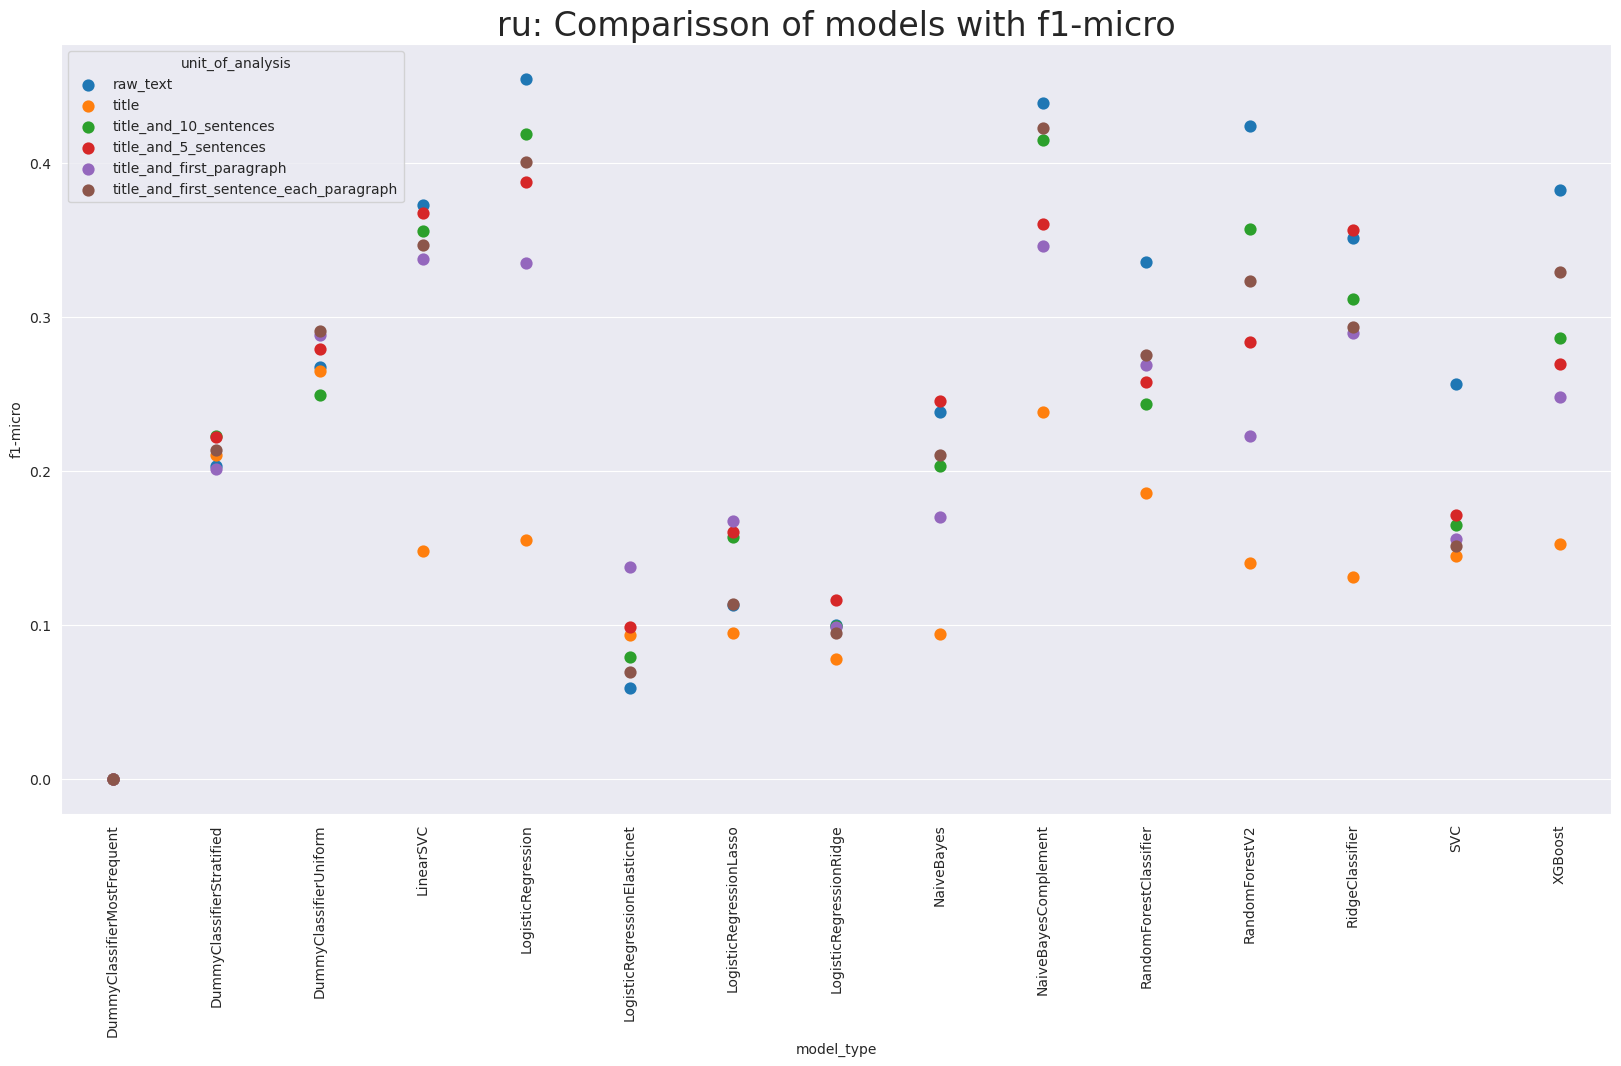

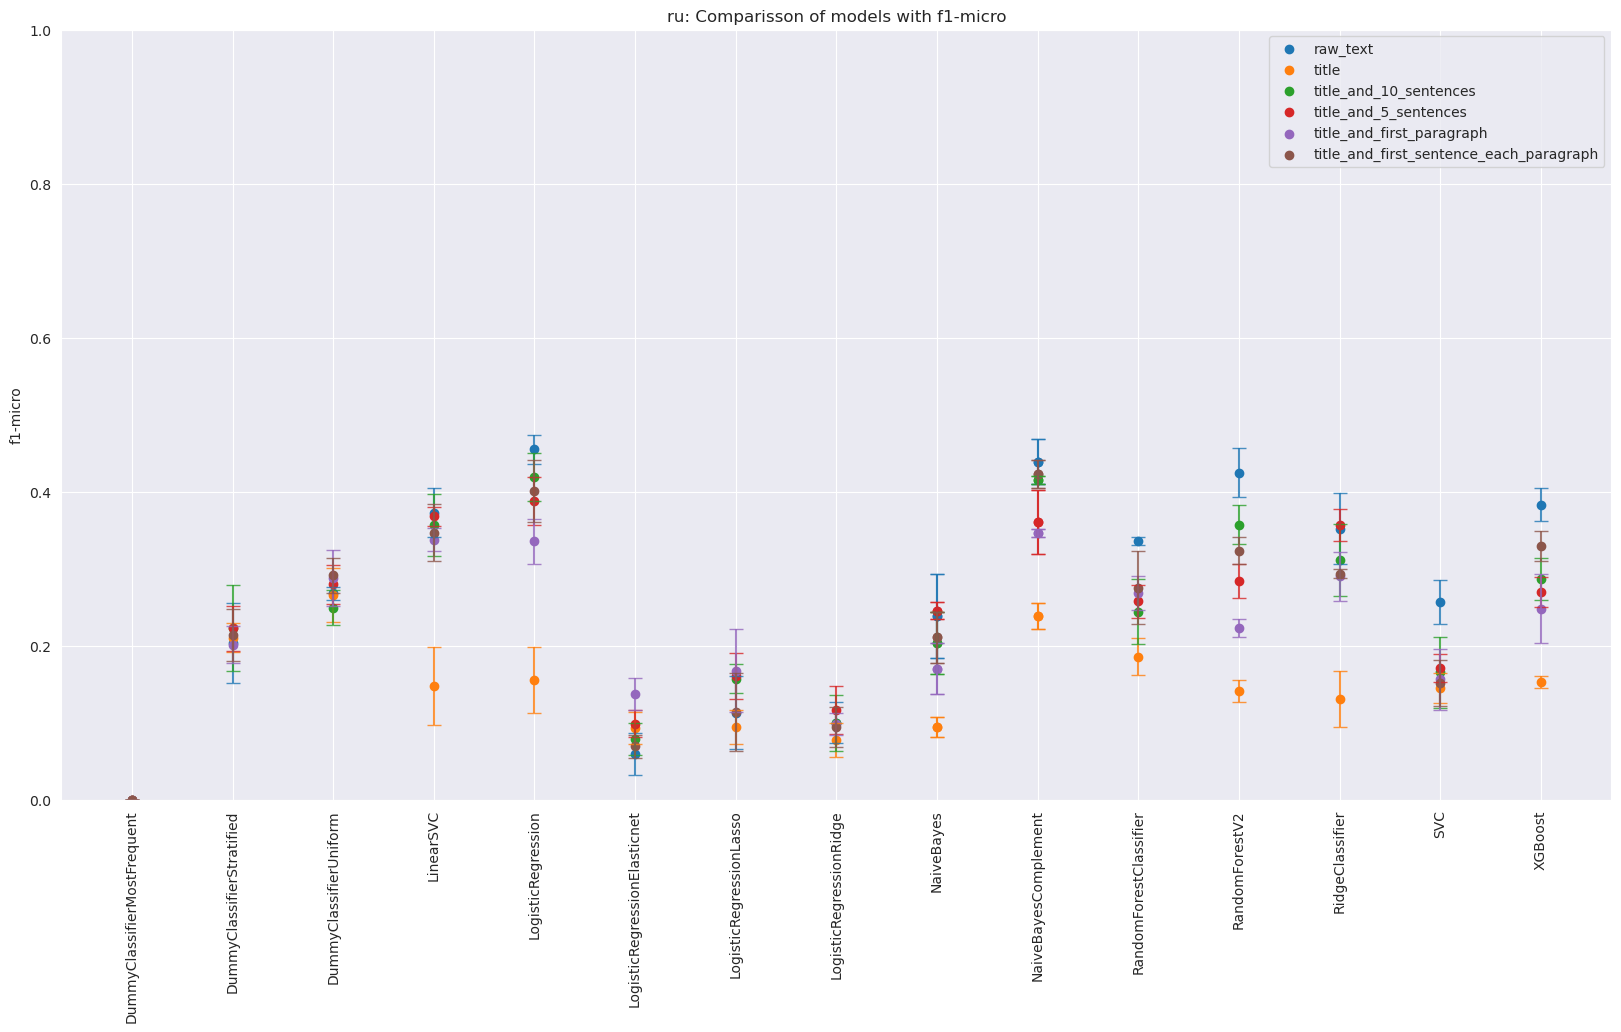



### f1-micro mean performance

| model_type                   | title (6 features)   | title and first paragraph (40 features)   | title and 5 sentences (134 features)   | title and 10 sentences (283 features)   | title and first sentence each paragraph (399 features)   | raw text (961 features)   |
|:-----------------------------|:---------------------|:------------------------------------------|:---------------------------------------|:----------------------------------------|:---------------------------------------------------------|:--------------------------|
| DummyClassifierMostFrequent  | 0.00 $\pm$ 0.00      | 0.00 $\pm$ 0.00                           | 0.00 $\pm$ 0.00                        | 0.00 $\pm$ 0.00                         | 0.00 $\pm$ 0.00                                          | 0.00 $\pm$ 0.00           |
| DummyClassifierStratified    | 0.21 $\pm$ 0.02      | 0.20 $\pm$ 0.02                           | 0.22 $\pm$ 0.03                        | 0.22 $\pm$ 0.06                         | 0.21 $\pm$ 0.03                                          | 0.20 $\pm$ 0.05           |
| DummyClassifierUniform       | 0.27 $\pm$ 0.04      | 0.29 $\pm$ 0.04                           | 0.28 $\pm$ 0.03                        | 0.25 $\pm$ 0.02                         | 0.29 $\pm$ 0.02                                          | 0.27 $\pm$ 0.01           |
| LinearSVC                    | 0.15 $\pm$ 0.05      | 0.34 $\pm$ 0.02                           | 0.37 $\pm$ 0.01                        | 0.36 $\pm$ 0.04                         | 0.35 $\pm$ 0.04                                          | 0.37 $\pm$ 0.03           |
| LogisticRegression           | 0.16 $\pm$ 0.04      | 0.34 $\pm$ 0.03                           | 0.39 $\pm$ 0.03                        | 0.42 $\pm$ 0.03                         | 0.40 $\pm$ 0.04                                          | **0.45 $\pm$ 0.02**       |
| LogisticRegressionElasticnet | 0.09 $\pm$ 0.02      | 0.14 $\pm$ 0.02                           | 0.10 $\pm$ 0.02                        | 0.08 $\pm$ 0.02                         | 0.07 $\pm$ 0.02                                          | 0.06 $\pm$ 0.03           |
| LogisticRegressionLasso      | 0.09 $\pm$ 0.02      | 0.17 $\pm$ 0.05                           | 0.16 $\pm$ 0.03                        | 0.16 $\pm$ 0.02                         | 0.11 $\pm$ 0.05                                          | 0.11 $\pm$ 0.05           |
| LogisticRegressionRidge      | 0.08 $\pm$ 0.02      | 0.10 $\pm$ 0.01                           | 0.12 $\pm$ 0.03                        | 0.10 $\pm$ 0.04                         | 0.09 $\pm$ 0.03                                          | 0.10 $\pm$ 0.03           |
| NaiveBayes                   | 0.09 $\pm$ 0.01      | 0.17 $\pm$ 0.03                           | 0.25 $\pm$ 0.01                        | 0.20 $\pm$ 0.04                         | 0.21 $\pm$ 0.03                                          | 0.24 $\pm$ 0.05           |
| NaiveBayesComplement         | 0.24 $\pm$ 0.02      | 0.35 $\pm$ 0.01                           | 0.36 $\pm$ 0.04                        | 0.41 $\pm$ 0.01                         | 0.42 $\pm$ 0.02                                          | 0.44 $\pm$ 0.03           |
| RandomForestClassifier       | 0.19 $\pm$ 0.02      | 0.27 $\pm$ 0.02                           | 0.26 $\pm$ 0.02                        | 0.24 $\pm$ 0.04                         | 0.28 $\pm$ 0.05                                          | 0.34 $\pm$ 0.01           |
| RandomForestV2               | 0.14 $\pm$ 0.01      | 0.22 $\pm$ 0.01                           | 0.28 $\pm$ 0.02                        | 0.36 $\pm$ 0.02                         | 0.32 $\pm$ 0.02                                          | 0.42 $\pm$ 0.03           |
| RidgeClassifier              | 0.13 $\pm$ 0.04      | 0.29 $\pm$ 0.03                           | 0.36 $\pm$ 0.02                        | 0.31 $\pm$ 0.05                         | 0.29 $\pm$ 0.01                                          | 0.35 $\pm$ 0.05           |
| SVC                          | 0.14 $\pm$ 0.02      | 0.16 $\pm$ 0.04                           | 0.17 $\pm$ 0.02                        | 0.16 $\pm$ 0.05                         | 0.15 $\pm$ 0.03                                          | 0.26 $\pm$ 0.03           |
| XGBoost                      | 0.15 $\pm$ 0.01      | 0.25 $\pm$ 0.04                           | 0.27 $\pm$ 0.02                        | 0.29 $\pm$ 0.03                         | 0.33 $\pm$ 0.02                                          | 0.38 $\pm$ 0.02           |

# Performance in the language: ge

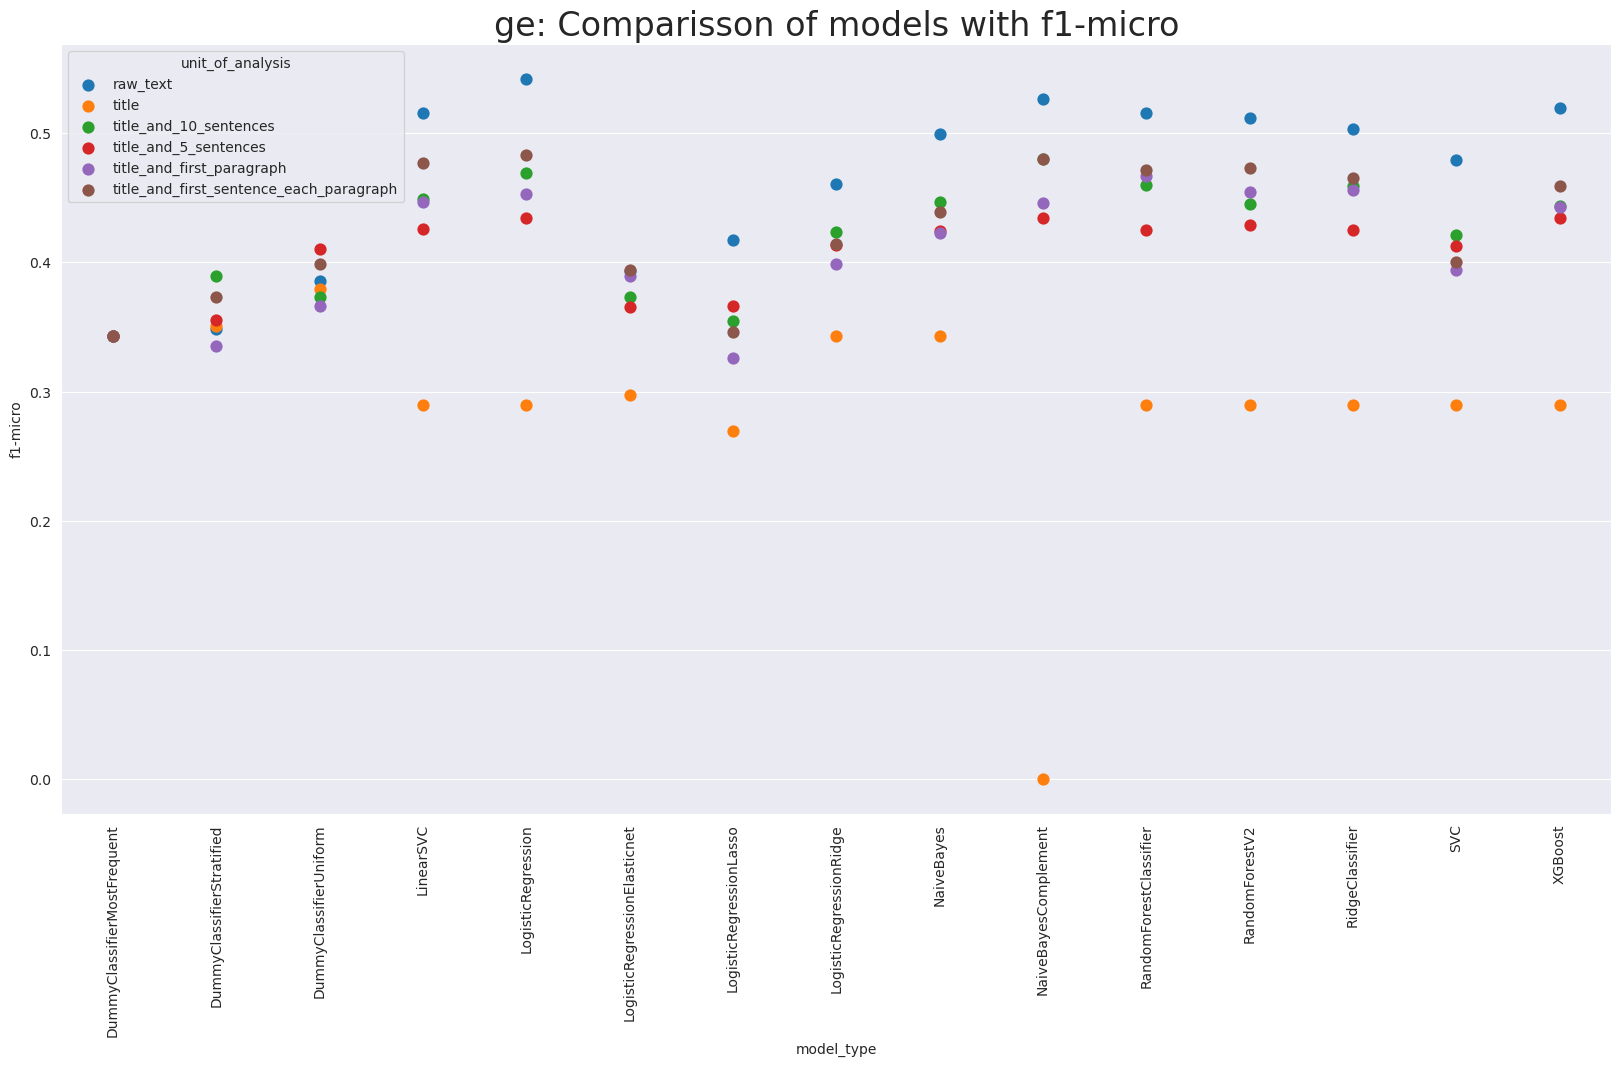

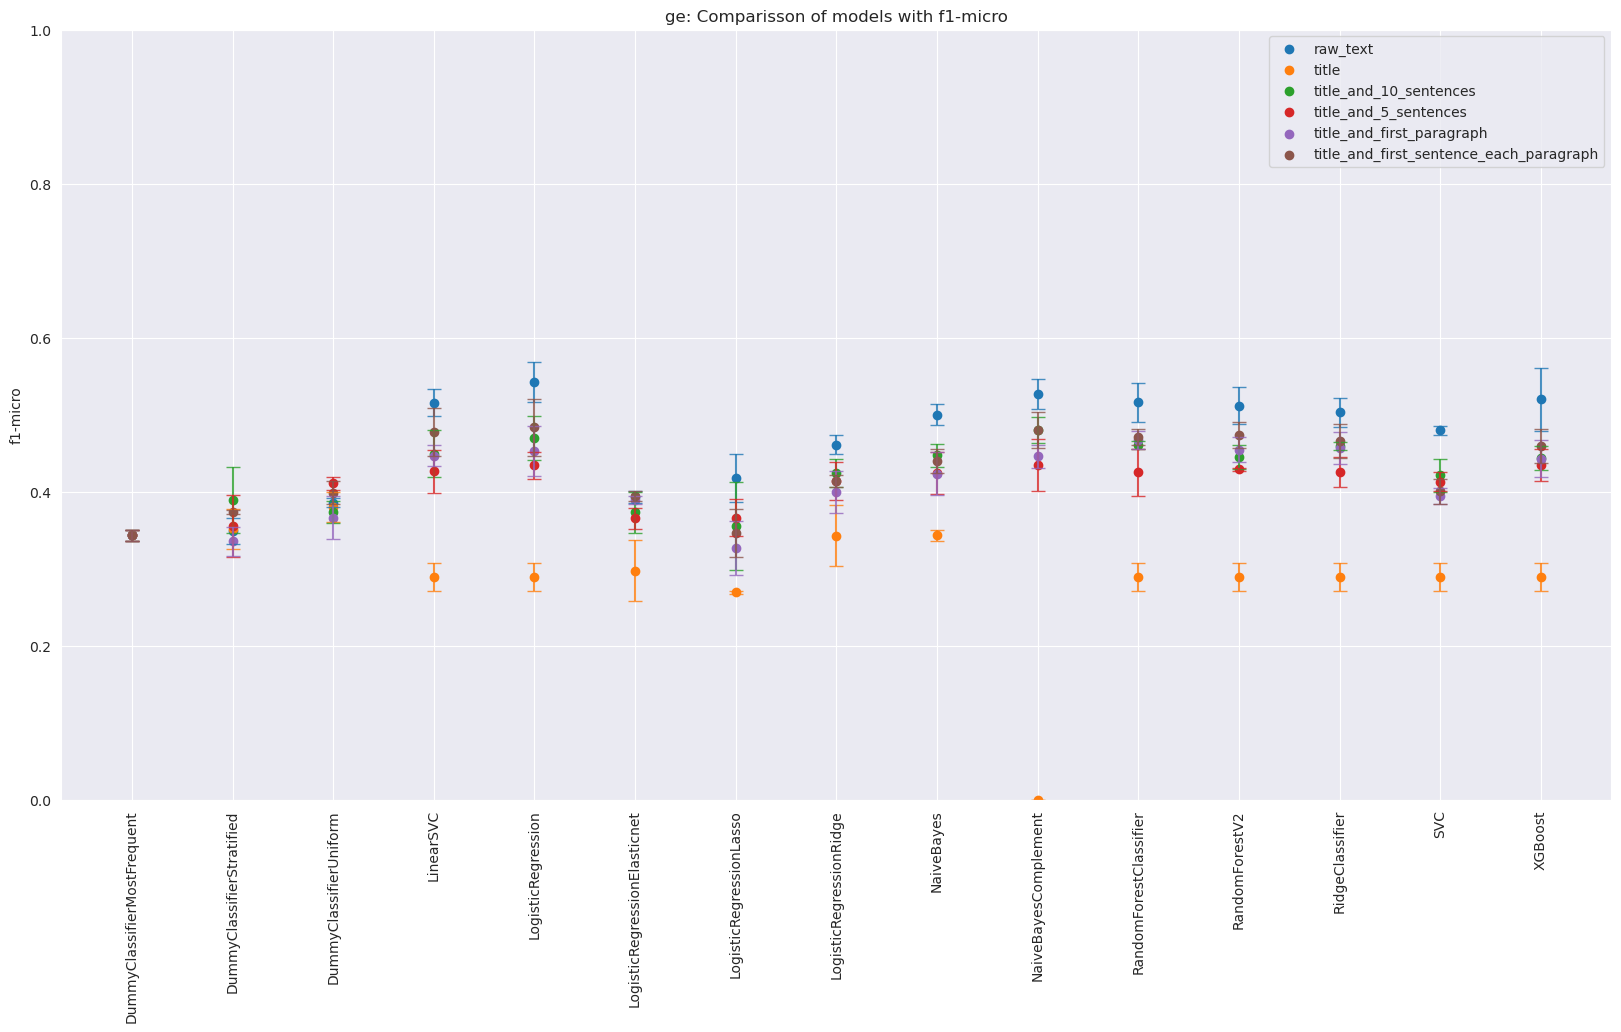



### f1-micro mean performance

| model_type                   | title (1 features)   | title and first paragraph (40 features)   | title and 5 sentences (61 features)   | title and 10 sentences (141 features)   | title and first sentence each paragraph (215 features)   | raw text (731 features)   |
|:-----------------------------|:---------------------|:------------------------------------------|:--------------------------------------|:----------------------------------------|:---------------------------------------------------------|:--------------------------|
| DummyClassifierMostFrequent  | 0.34 $\pm$ 0.01      | 0.34 $\pm$ 0.01                           | 0.34 $\pm$ 0.01                       | 0.34 $\pm$ 0.01                         | 0.34 $\pm$ 0.01                                          | 0.34 $\pm$ 0.01           |
| DummyClassifierStratified    | 0.35 $\pm$ 0.03      | 0.34 $\pm$ 0.02                           | 0.36 $\pm$ 0.04                       | 0.39 $\pm$ 0.04                         | 0.37 $\pm$ 0.00                                          | 0.35 $\pm$ 0.02           |
| DummyClassifierUniform       | 0.38 $\pm$ 0.02      | 0.37 $\pm$ 0.03                           | 0.41 $\pm$ 0.01                       | 0.37 $\pm$ 0.01                         | 0.40 $\pm$ 0.01                                          | 0.39 $\pm$ 0.01           |
| LinearSVC                    | 0.29 $\pm$ 0.02      | 0.45 $\pm$ 0.01                           | 0.43 $\pm$ 0.03                       | 0.45 $\pm$ 0.03                         | 0.48 $\pm$ 0.03                                          | 0.52 $\pm$ 0.02           |
| LogisticRegression           | 0.29 $\pm$ 0.02      | 0.45 $\pm$ 0.03                           | 0.43 $\pm$ 0.02                       | 0.47 $\pm$ 0.03                         | 0.48 $\pm$ 0.04                                          | **0.54 $\pm$ 0.03**       |
| LogisticRegressionElasticnet | 0.30 $\pm$ 0.04      | 0.39 $\pm$ 0.00                           | 0.37 $\pm$ 0.01                       | 0.37 $\pm$ 0.03                         | 0.39 $\pm$ 0.01                                          | 0.39 $\pm$ 0.01           |
| LogisticRegressionLasso      | 0.27 $\pm$ 0.00      | 0.33 $\pm$ 0.04                           | 0.37 $\pm$ 0.02                       | 0.35 $\pm$ 0.06                         | 0.35 $\pm$ 0.03                                          | 0.42 $\pm$ 0.03           |
| LogisticRegressionRidge      | 0.34 $\pm$ 0.04      | 0.40 $\pm$ 0.03                           | 0.41 $\pm$ 0.02                       | 0.42 $\pm$ 0.02                         | 0.41 $\pm$ 0.01                                          | 0.46 $\pm$ 0.01           |
| NaiveBayes                   | 0.34 $\pm$ 0.01      | 0.42 $\pm$ 0.03                           | 0.42 $\pm$ 0.03                       | 0.45 $\pm$ 0.02                         | 0.44 $\pm$ 0.02                                          | 0.50 $\pm$ 0.01           |
| NaiveBayesComplement         | 0.00 $\pm$ 0.00      | 0.45 $\pm$ 0.01                           | 0.43 $\pm$ 0.03                       | 0.48 $\pm$ 0.02                         | 0.48 $\pm$ 0.02                                          | 0.53 $\pm$ 0.02           |
| RandomForestClassifier       | 0.29 $\pm$ 0.02      | 0.47 $\pm$ 0.01                           | 0.42 $\pm$ 0.03                       | 0.46 $\pm$ 0.01                         | 0.47 $\pm$ 0.01                                          | 0.52 $\pm$ 0.03           |
| RandomForestV2               | 0.29 $\pm$ 0.02      | 0.45 $\pm$ 0.02                           | 0.43 $\pm$ 0.00                       | 0.45 $\pm$ 0.02                         | 0.47 $\pm$ 0.02                                          | 0.51 $\pm$ 0.02           |
| RidgeClassifier              | 0.29 $\pm$ 0.02      | 0.46 $\pm$ 0.02                           | 0.43 $\pm$ 0.02                       | 0.46 $\pm$ 0.01                         | 0.47 $\pm$ 0.02                                          | 0.50 $\pm$ 0.02           |
| SVC                          | 0.29 $\pm$ 0.02      | 0.39 $\pm$ 0.01                           | 0.41 $\pm$ 0.01                       | 0.42 $\pm$ 0.02                         | 0.40 $\pm$ 0.02                                          | 0.48 $\pm$ 0.01           |
| XGBoost                      | 0.29 $\pm$ 0.02      | 0.44 $\pm$ 0.02                           | 0.43 $\pm$ 0.02                       | 0.44 $\pm$ 0.02                         | 0.46 $\pm$ 0.02                                          | 0.52 $\pm$ 0.04           |

In [5]:
results_df = load_results_dataset('runsDefaultCV3.csv', metric='f1_micro')

for language, df in results_df.groupby('language'):
    display(Markdown(f'# Performance in the language: {language}'))

    plot_performance_wo_error_bars(df, title=f'{language}: Comparisson of models with f1-micro')

    plot_performance_with_error_bars(df, title=f'{language}: Comparisson of models with f1-micro')

    display(Markdown(f'\n\n### f1-micro mean performance'))
    display_performance_table(df)

    print('\n\n')

In [6]:
with open("Performance table.md", "w") as file:
    for language, df in results_df.groupby('language'):
        file.write(f'# Performance in the language: {language}\n')
        file.write(f'### f1-micro mean performance\n')
        file.write(display_performance_table(df, display_=False))
        file.write('\n\n')
    file.close()